# Target-embedded autoencoders

In [1]:
import typing
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import torch.nn.functional as F

from fastai.basics import DataBunch # used for easy batching

from tea_models import LinearAE, LinearFEA

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

### Load data, set model paramaters 

In [3]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
chip_features = pd.read_csv("data/net1_chip_features.tsv", sep='\t')
gene_ids = pd.read_csv("data/net1_gene_ids.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')

In [4]:
X_idx = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]

In [5]:
synthetic_expression_data.values.shape

(805, 1643)

In [6]:
train, valid, test = map(torch.FloatTensor, (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :]))

In [7]:
batch_size = 128
train_ds = TensorDataset(train[:, X_idx], train)
valid_ds = TensorDataset(valid[:, X_idx], valid)
test_ds = TensorDataset(test[:, X_idx], test)
train_dl = DataLoader(train_ds, batch_size)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [8]:
# these also give us some shape values for later
X, Y = next(iter(train_ds))
X.shape, Y.shape

(torch.Size([194]), torch.Size([1643]))

In [9]:
input_dim = sum(X_idx)
hidden_dim = 256
output_dim = synthetic_expression_data.shape[1]

### First, train a simple linear autoencoder 

In [10]:
lae_model = LinearAE(input_dim, hidden_dim)
lae_model

LinearAE(
  (input): Linear(in_features=194, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=194, bias=True)
)

In [11]:
# train the linear AE
epochs = 100
lr = 2e-3
opt = optim.Adam(lae_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []

In [12]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([lae_model.update_batch(X, opt, mse) for X, _ in train_dl])
    this_valid_loss = np.mean([lae_model.update_batch(X, opt, mse, train=False) for X, _ in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 100/100 [00:01<00:00, 59.01it/s]


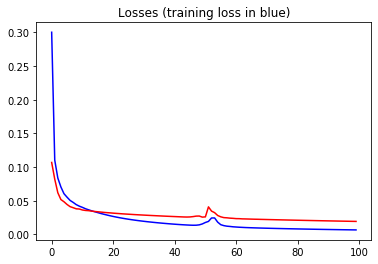

In [13]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Final validation loss 

In [14]:
print("Final valid loss: {}".format(valid_loss[-1]))

Final valid loss: 0.019216670654714108


### Visualise predicted vs. actual

In [15]:
# pick a row, generate predictions
idx = 10
X, Y = test_ds[idx]
# Y_hat, X_tilde = lfea_model(X)
X_tilde = lae_model(X)

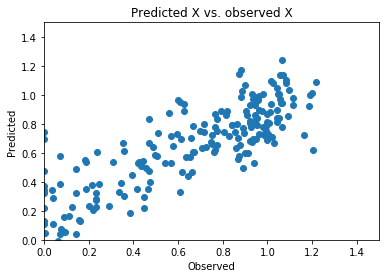

In [16]:
# X_tilde vs. X
plt.scatter(X.detach().numpy(), X_tilde.detach().numpy())
plt.title("Predicted X vs. observed X");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

### Now use these weights in a FEA

In [17]:
class joint_loss(nn.Module):
    """
    Parameters
    ----------
    lambda_ : float
        Weighting in the joint joss. 
        Higher lambda_ favours lower reconstruction loss.
    """
    def __init__(self, lambda_=0.5):
        super().__init__()
        self.X = X
        self.Y = Y
        self.lambda_ = lambda_
        
    def forward(self, X, X_tilde, Y, Y_hat):
        mse = nn.MSELoss()
        return ( ((1 - self.lambda_) * mse(Y_hat, Y)) + (self.lambda_ * mse(X_tilde, X)) )

In [52]:
lfea_model = LinearFEA(input_dim, hidden_dim, output_dim)
lfea_model

LinearFEA(
  (input): Linear(in_features=194, out_features=256, bias=True)
  (predict_Y): Linear(in_features=256, out_features=1643, bias=True)
  (reconstruct_X): Linear(in_features=256, out_features=194, bias=True)
)

### Copy the weights and biases from the trained AE

In [41]:
lfea_model.input.load_state_dict(lae_model.input.state_dict(), strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [42]:
lfea_model.reconstruct_X.load_state_dict(lae_model.output.state_dict(), strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [53]:
# train the linear FEA
epochs = 60
lr = 6e-3
opt = optim.Adam(lfea_model.parameters(), lr)
criterion = joint_loss(lambda_= 0)
train_loss, valid_loss = [], []

In [54]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([lfea_model.update_batch(X, Y, opt, criterion) for X, Y in train_dl])
    this_valid_loss = np.mean([lfea_model.update_batch(X, Y, opt, criterion, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 60/60 [00:02<00:00, 26.34it/s]


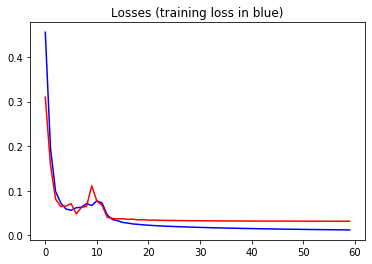

In [55]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Final validation loss

In [56]:
print("Final valid loss: {}".format(valid_loss[-1]))

Final valid loss: 0.03172141872346401


### Visualise predicted vs. actual

In [57]:
# pick a row, generate predictions
idx = 10
X, Y = test_ds[idx]
Y_hat, X_tilde = lfea_model(X)
# X_tilde = lae_model(X)

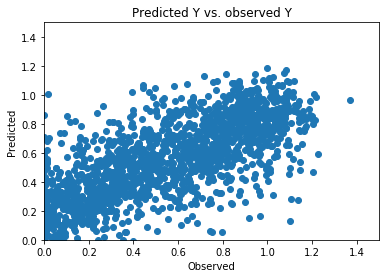

In [58]:
# Y_hat vs Y
plt.scatter(Y.detach().numpy(), Y_hat.detach().numpy())
plt.title("Predicted Y vs. observed Y");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

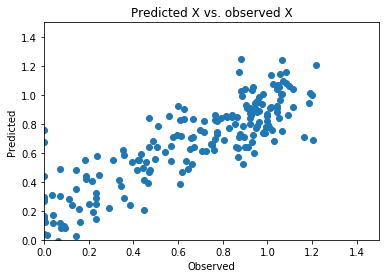

In [49]:
# X_tilde vs. X
plt.scatter(X.detach().numpy(), X_tilde.detach().numpy())
plt.title("Predicted X vs. observed X");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

### Test loss 

In [50]:
# test losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat, _ = lfea_model(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final test MSE loss on prediction task: 0.03618953377008438


In [51]:
gc.collect()

22530